In [19]:
import numpy as np
import cv2
from scipy.linalg import orthogonal_procrustes
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
import copy
import scipy
import matplotlib.pyplot as plt

In [2]:
demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
# Write your code here
def draw_registration_result(source, target, transformation):
    """
    param: source - source point cloud
    param: target - target point cloud
    param: transformation - 4 X 4 homogeneous transformation matrix
    """
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
    zoom=0.4459,
    front=[0.9288, -0.2951, -0.2242],
    lookat=[1.6784, 2.0612, 1.4451],
    up=[-0.3402, -0.9189, -0.1996])

In [3]:
source_points = np.asarray(source.points)
target_points = np.asarray(target.points)

In [4]:
source_points.shape

(198835, 3)

In [5]:
target_points.shape

(137833, 3)

# Finding the transformation using ICP API

In [6]:
threshold = 0.02
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=3.724495e-01, inlier_rmse=7.760179e-03, and correspondence_set size of 74056
Access transformation to get result.
Transformation is:
[[ 0.83924644  0.01006041 -0.54390867  0.64639961]
 [-0.15102344  0.96521988 -0.21491604  0.75166079]
 [ 0.52191123  0.2616952   0.81146378 -1.50303533]
 [ 0.          0.          0.          1.        ]]


# Finding the transformation using implementation of ICP from scratch

In [15]:
class ICP_algo:
    def __init__(self,source_point_cloud = None, target_point_cloud = None):
        self.source = source_point_cloud
        self.target = target_point_cloud
    
    def find_correspondences(self,source,target):
        # Need to find the nearest point/ correspondences to the target point
        source_kd_tree = o3d.geometry.KDTreeFlann(source)
        index = []
        for i,pts in enumerate(target.points):            
            [k,idx, _] = source_kd_tree.search_knn_vector_3d(pts,1)            
            index.append(idx[0])

        correspondences = list(zip(index,list(range(len(target.points)))))

        return correspondences
    
    def icp(self,init_pose=None, max_iterations=100, tolerance=0.001):

        # apply the initial pose estimation
        if init_pose is not None:
            src = np.dot(init_pose, src)
        
        source_temp = copy.deepcopy(self.source)
        target_temp = copy.deepcopy(self.target)
        target_points = np.asarray(target_temp.points).T

        dist_values = []
        list_T = []
        prev_error = 0
        
#         for i in range(max_iterations):
        while(True):
            correspondences = self.find_correspondences(source_temp, target_temp)
            source_points = np.asarray(source_temp.points).T

            source_correspondences = source_points[:,np.array(correspondences)[:,0]]
            target_correspondences = target_points[:,np.array(correspondences)[:,1]]
            
            # Finding the mean of the correspondences of both source and target points
            centroid_source = np.mean(source_correspondences,axis = 1).reshape(-1,1)
            centroid_target = np.mean(target_correspondences,axis = 1).reshape(-1,1)
            
            source_mean = source_correspondences - centroid_source
            target_mean = target_correspondences - centroid_source
            
            # Calculating the error
            
            dist_values.append(np.linalg.norm(target_mean - source_mean))
            
            
            H = target_mean @ source_mean.T
            U, S, V = np.linalg.svd(H)
            R = U.dot(V)
            # special reflection case
            if np.linalg.det(R) < 0:
                V[:,2] *= -1
                R = np.dot(U,V)

            t = centroid_target - R.dot(centroid_source)    
            T = np.concatenate([R,t],axis=1)
            T = np.concatenate([T,[[0.,0.,0.,1.]]],axis = 0)
            
            # Storing all the transformation matrices
            list_T.append(T)
            # Transforming the source
            source_temp.transform(T)
            
            # Check error
            mean_error = np.linalg.norm(target_mean - source_mean)
            
            if np.abs(prev_error - mean_error) < tolerance:
                break
                
            prev_error = mean_error                      


        return list_T, dist_values, source_temp

In [ ]:
if __name__ == '__main__':
    model = ICP_algo(source,target)
    T, err, src = model.icp()

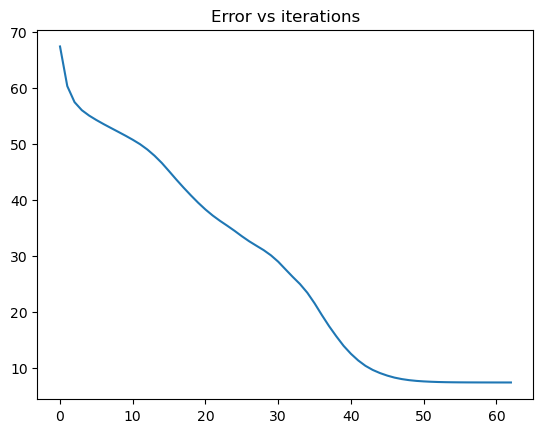

In [20]:
# Plotting the error
plt.plot(err)
plt.title("Error vs iterations");

In [17]:
# The final transformation matrix 
T_final = np.eye(4)

for i in T:
    T_final = i @ T_final 
print(T_final)

[[ 0.84400553  0.00796449 -0.53627534  0.6430298 ]
 [-0.14830667  0.9643682  -0.21908698  0.81212336]
 [ 0.51542197  0.26444384  0.81511328 -1.47435384]
 [ 0.          0.          0.          1.        ]]


In [24]:
draw_registration_result(source, target, T_final)

# Part(b)

In [23]:
pcd1 = o3d.io.read_point_cloud('kitti_frame1.pcd')
pcd2 = o3d.io.read_point_cloud('kitti_frame2.pcd')

In [29]:
if __name__ == '__main__':
    model_test = ICP_algo(pcd1,pcd2)
    T_test, err_test, src_test = model_test.icp()

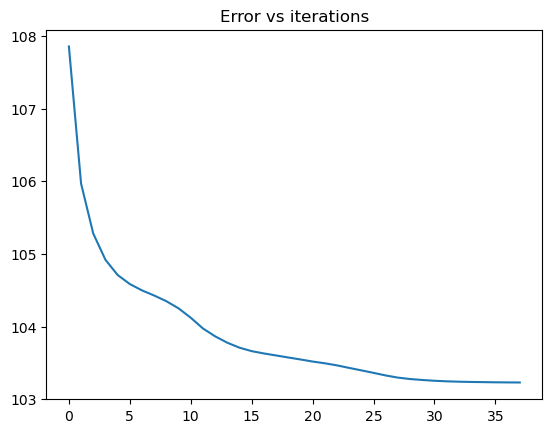

In [30]:
# Plotting the error
plt.plot(err)
plt.title("Error vs iterations");

In [31]:
# The final transformation matrix 
T_final_test = np.eye(4)
for i in T:
    T_final_test = i @ T_final 
print(T_final)

[[ 0.99993754  0.01028608  0.00437079 -1.22042295]
 [-0.01027192  0.99994196 -0.00325139 -0.3935267 ]
 [-0.00440398  0.00320629  0.99998516  0.10912976]
 [ 0.          0.          0.          1.        ]]


In [32]:
draw_registration_result(pcd1,pcd2,T_final_test)